In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load the data

In [2]:
data = pd.read_csv( "train.csv" )

In [3]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Find columns containing `NaN`'s

In [4]:
data.isna().any()

User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

It appears that the only columns that contain `Nan` values are product categories. To fix this problem we will add one extra product category (0) that indicates that this product does not have a second/third product category.

In [5]:
data.Product_Category_2.fillna(0, inplace = True )
data.Product_Category_3.fillna(0, inplace = True )

data["Product_Category_1"] = data["Product_Category_1"].apply( lambda x : int(x) )
data["Product_Category_2"] = data["Product_Category_2"].apply( lambda x : int(x) )
data["Product_Category_3"] = data["Product_Category_3"].apply( lambda x : int(x) )

## Convert the string data to numerical category labels

In [6]:
def ageToCategory( ageStr ):

    if (ageStr == "0-17"):
        return 0

    elif (ageStr == "18-25"):
        return 1

    elif (ageStr == "26-35"):
        return 2

    elif (ageStr == "36-45"):
        return 3

    elif (ageStr == "46-50"):
        return 4

    elif (ageStr == "51-55"):
        return 5

    elif (ageStr == "55+"):
        return 6

def sexToCategory( sexStr ):

    if (sexStr == "M"):
        return 0

    else:
        return 1

def cityToCategory( cityStr ):

    if (cityStr == "A"):
        return 0

    elif (cityStr == "B"):
        return 1

    else:
        return 2

def stayToCategory( stayStr ):
    
    try:
        category = int( stayStr )
        
    except ValueError:
        return 4
    
    else:
        return category
    

In [7]:
data["Age"] = data["Age"].apply( ageToCategory )
data["Gender"] = data["Gender"].apply( sexToCategory )
data["City_Category"] = data["City_Category"].apply( cityToCategory )
data["Stay_In_Current_City_Years"] = data["Stay_In_Current_City_Years"].apply( stayToCategory )

In [8]:
data.describe()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,0.246895,2.496430,8.076707,1.042640,1.858418,0.409653,5.404270,6.735436,3.841941,9263.968713
std,1.727592e+03,0.431205,1.353632,6.522660,0.760211,1.289443,0.491770,3.936211,6.215492,6.250712,5023.065394
min,1.000001e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000
25%,1.001516e+06,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5823.000000
50%,1.003077e+06,0.000000,2.000000,7.000000,1.000000,2.000000,0.000000,5.000000,5.000000,0.000000,8047.000000
75%,1.004478e+06,0.000000,3.000000,14.000000,2.000000,3.000000,1.000000,8.000000,14.000000,8.000000,12054.000000
max,1.006040e+06,1.000000,6.000000,20.000000,2.000000,4.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


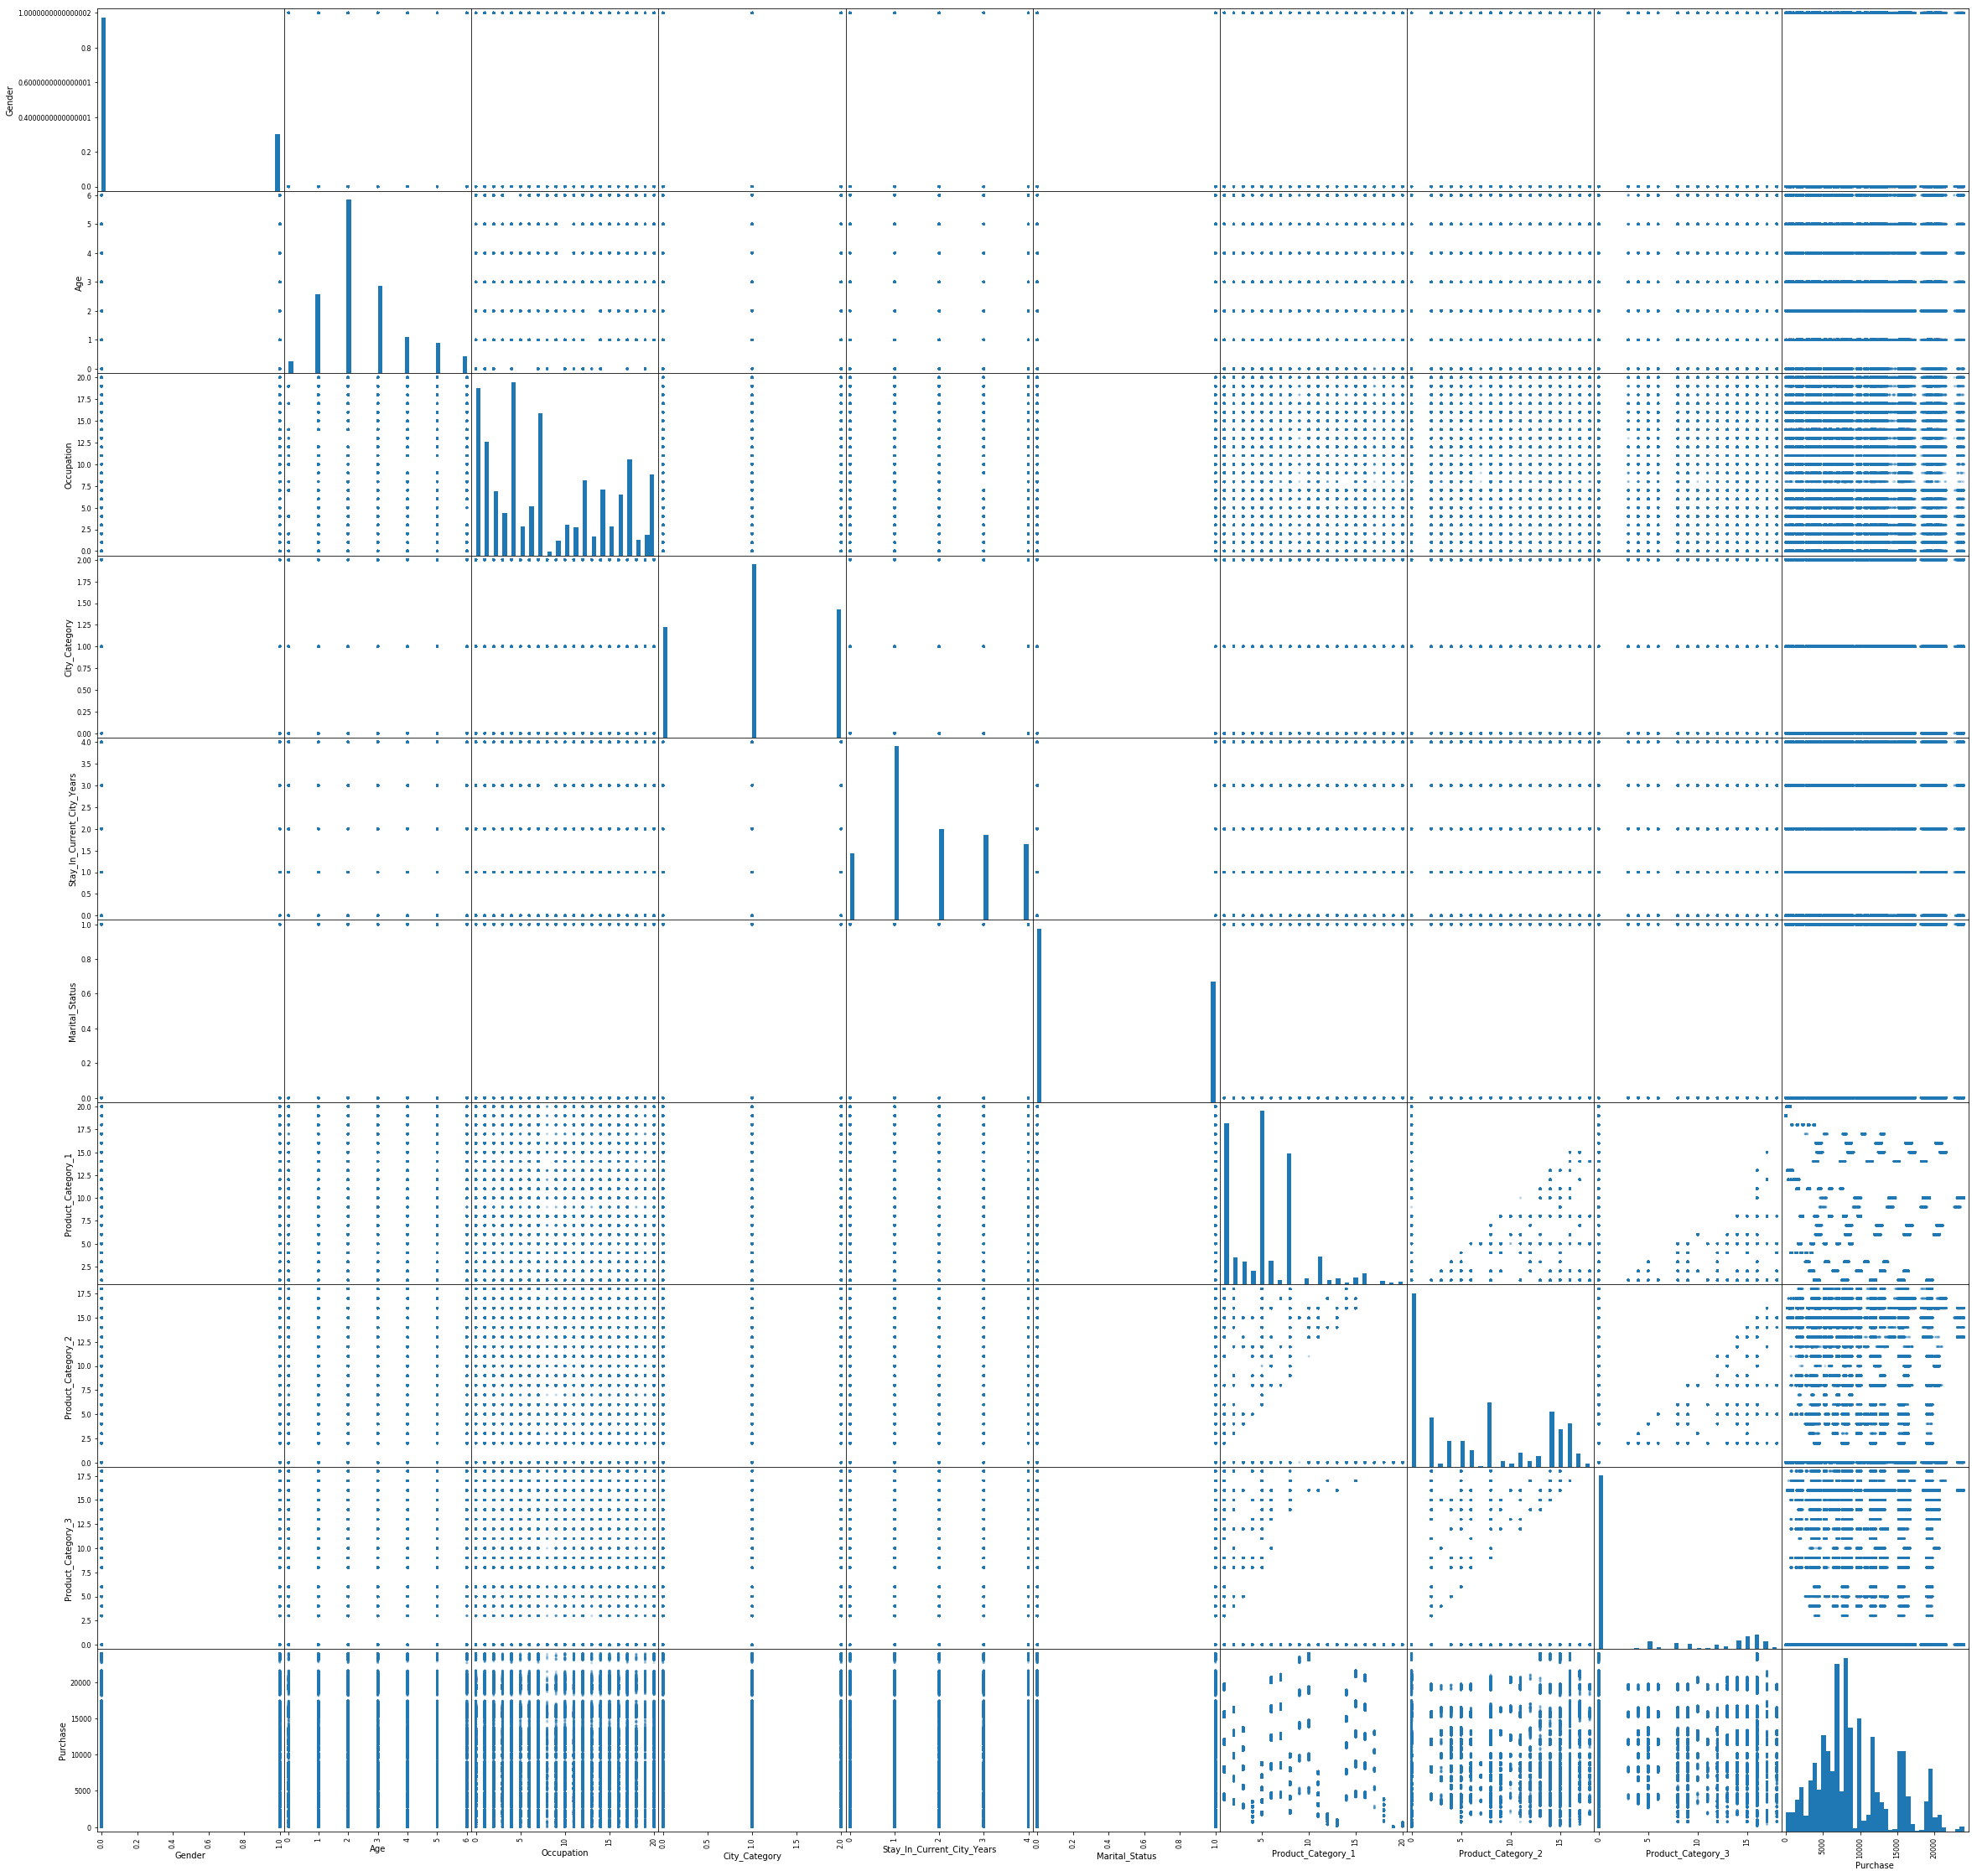

In [9]:
pd.plotting.scatter_matrix( data.drop( ["User_ID", "Product_ID"], axis = 1 ),
                            figsize = (40, 40), alpha = 0.3,
                            hist_kwds = { "bins" : 40 } )
plt.show()

In [10]:
data.drop( ["User_ID", "Product_ID"], axis = 1 ).corr()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
Gender,1.000000,0.004262,-0.117291,0.004515,-0.014660,0.011603,0.045594,0.000954,-0.036146,-0.060346
Age,0.004262,1.000000,0.091463,0.123079,-0.004712,0.311738,0.061197,0.018770,-0.007422,0.015839
Occupation,-0.117291,0.091463,1.000000,0.034479,0.030005,0.024280,-0.007618,0.006712,0.012269,0.020833
City_Category,0.004515,0.123079,0.034479,1.000000,0.019946,0.039790,-0.014364,0.016003,0.035525,0.061914
Stay_In_Current_City_Years,-0.014660,-0.004712,0.030005,0.019946,1.000000,-0.012819,-0.004213,0.001262,0.001977,0.005422
Marital_Status,0.011603,0.311738,0.024280,0.039790,-0.012819,1.000000,0.019888,0.001099,-0.004629,-0.000463
Product_Category_1,0.045594,0.061197,-0.007618,-0.014364,-0.004213,0.019888,1.000000,-0.067877,-0.385534,-0.343703
Product_Category_2,0.000954,0.018770,0.006712,0.016003,0.001262,0.001099,-0.067877,1.000000,0.094750,0.052288
Product_Category_3,-0.036146,-0.007422,0.012269,0.035525,0.001977,-0.004629,-0.385534,0.094750,1.000000,0.288501
Purchase,-0.060346,0.015839,0.020833,0.061914,0.005422,-0.000463,-0.343703,0.052288,0.288501,1.000000


## Prepare the data

Categorical data with more than two categories will be one-hot encoded. The three product categories will be combined into one 20-dimensional vector with a one in any applicable category slots.

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

def catToVector( catNum ):
    if (catNum == 0):
        return np.zeros(20)

    else:
        return np.eye( 20 )[catNum - 1]

class ThreeHotEncodeProducts(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.vstack( X.Product_Category_1.apply(catToVector).values +\
                          X.Product_Category_2.apply(catToVector).values +\
                          X.Product_Category_3.apply(catToVector).values )

In [12]:
gender = Pipeline([ ("select", DataFrameSelector(["Gender"])) ])

age = Pipeline([ ("select", DataFrameSelector(["Age"])),
                 ("onehot", OneHotEncoder(sparse = False)) ])

job = Pipeline([ ("select", DataFrameSelector(["Occupation"])),
                 ("onehot", OneHotEncoder(sparse = False)) ])

city = Pipeline([ ("select", DataFrameSelector(["City_Category"])),
                  ("onehot", OneHotEncoder(sparse = False)) ])

stay = Pipeline([ ("select", DataFrameSelector(["Stay_In_Current_City_Years"])),
                  ("onehot", OneHotEncoder(sparse = False)) ])

marStat = Pipeline([ ("select", DataFrameSelector(["Marital_Status"])) ])

prodCat = Pipeline([ ("products", ThreeHotEncodeProducts()) ])

dataPrep = FeatureUnion( transformer_list=[ ("gender", gender),
                                            ("age", age),
                                            ("job", job),
                                            ("city", city),
                                            ("stay", stay),
                                            ("marStatus", marStat),
                                            ("prodCat", prodCat) ] )

In [13]:
features = dataPrep.fit_transform( data )
targets  = data.Purchase.values

## Split the data

In [14]:
xTrain, xTest, yTrain, yTest = train_test_split( features, targets,
                                                 test_size = 0.2,
                                                 random_state = 0 )

xTrain, xVal, yTrain, yVal = train_test_split( xTrain, yTrain,
                                               test_size = 0.1,
                                               random_state = 10 )

## Scale the data

In [15]:
pMin = np.min( yTrain )
pMax = np.max( yTrain )

yTrain = ( yTrain - pMin ) / ( pMax - pMin )
yVal = ( yVal - pMin ) / ( pMax - pMin )
yTest = ( yTest - pMin ) / ( pMax - pMin )

## Build/train a model

In [16]:
def genModel( nh = 50, nlayers = 1 ):

    model = Sequential()

    model.add( Dense(nh, input_shape=(58,), activation = "elu" ) )

    for _ in range( nlayers - 1):
        model.add( BatchNormalization() )
        model.add( Dense(nh, activation = "elu" ) )

    model.add( Dense(1, activation = "relu") )

    model.compile( optimizer = "adam", loss = "mse" )

    return model


In [17]:
model = genModel( nlayers = 10, nh = 50 )

earlyStoper  = EarlyStopping( patience = 10, verbose = 1 )
checkPointer = ModelCheckpoint( filepath = "best.hdf5", save_best_only = True, verbose = 1 )

hist = model.fit( xTrain, yTrain, validation_data = (xVal, yVal),
                  epochs = 1000, batch_size = 512, callbacks = [earlyStoper, checkPointer] )

Train on 396048 samples, validate on 44006 samples
Epoch 1/1000
394240/396048 [============================>.] - ETA: 0s - loss: 0.0264
Epoch 00001: val_loss improved from inf to 0.01662, saving model to best.hdf5
396048/396048 [==============================] - 10s 25us/step - loss: 0.0263 - val_loss: 0.0166
Epoch 2/1000
394240/396048 [============================>.] - ETA: 0s - loss: 0.0161
Epoch 00002: val_loss improved from 0.01662 to 0.01537, saving model to best.hdf5
396048/396048 [==============================] - 8s 21us/step - loss: 0.0161 - val_loss: 0.0154
Epoch 3/1000
395264/396048 [============================>.] - ETA: 0s - loss: 0.0157
Epoch 00003: val_loss did not improve
396048/396048 [==============================] - 8s 21us/step - loss: 0.0157 - val_loss: 0.0167
Epoch 4/1000
395264/396048 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 00004: val_loss did not improve
396048/396048 [==============================] - 9s 22us/step - loss: 0.0155 - val_l

393216/396048 [============================>.] - ETA: 0s - loss: 0.0141
Epoch 00035: val_loss did not improve
396048/396048 [==============================] - 8s 21us/step - loss: 0.0141 - val_loss: 0.0147
Epoch 36/1000
394752/396048 [============================>.] - ETA: 0s - loss: 0.0141
Epoch 00036: val_loss did not improve
396048/396048 [==============================] - 8s 21us/step - loss: 0.0141 - val_loss: 0.0147
Epoch 37/1000
394752/396048 [============================>.] - ETA: 0s - loss: 0.0141
Epoch 00037: val_loss did not improve
396048/396048 [==============================] - 8s 21us/step - loss: 0.0141 - val_loss: 0.0149
Epoch 38/1000
395264/396048 [============================>.] - ETA: 0s - loss: 0.0141
Epoch 00038: val_loss improved from 0.01469 to 0.01462, saving model to best.hdf5
396048/396048 [==============================] - 9s 21us/step - loss: 0.0141 - val_loss: 0.0146
Epoch 39/1000
393728/396048 [============================>.] - ETA: 0s - loss: 0.0140
Epoc

## Evaluate the model on the test data

In [18]:
model.load_weights( "best.hdf5" )
mseTrain = model.evaluate(xTrain, yTrain)
mseVal = model.evaluate(xVal, yVal)
mseTest = model.evaluate(xTest, yTest)

print("\n")
print( "MSE on the training set:   {:1.4e}".format(mseTrain) )
print( "MSE on the validation set: {:1.4e}".format(mseVal) )
print( "MSE on the test set:       {:1.4e}".format(mseTest) )

110014/110014 [==============================] - 7s 64us/step


MSE on the training set:   1.3795e-02
MSE on the validation set: 1.4622e-02
MSE on the test set:       1.4608e-02


In [19]:
print("Untransformed version:\n")
print( "Error on the training set:   {:3.1f}".format( np.sqrt(mseTrain) * (pMax - pMin) ) )
print( "Error on the validation set: {:3.1f}".format( np.sqrt(mseVal)   * (pMax - pMin) ) )
print( "Error on the test set:       {:3.1f}".format( np.sqrt(mseTest)  * (pMax - pMin) ) )

Untransformed version:

Error on the training set:   2812.9
Error on the validation set: 2895.9
Error on the test set:       2894.5


## Create lookup tables for user data nad product information

In [20]:
userData = data[ ["User_ID", "Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"] ]
userData.index = userData.User_ID
userData.drop( ["User_ID"], axis = 1, inplace = True )
userData.drop_duplicates( keep = "first", inplace = True )
userData.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
User_ID,,,,,,
1000001,1,0,10,0,2,0
1000002,0,6,16,2,4,0
1000003,0,2,15,0,3,0
1000004,0,4,7,1,2,1
1000005,0,2,20,0,1,1


In [21]:
productData = data[ ["Product_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3"] ]
productData.index = productData.Product_ID
productData.drop( ["Product_ID"], axis = 1, inplace = True )
productData.drop_duplicates( keep = "first", inplace = True )
productData.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Product_Category_1,Product_Category_2,Product_Category_3
Product_ID,,,
P00069042,3,0,0
P00248942,1,6,14
P00087842,12,0,0
P00085442,12,14,0
P00285442,8,0,0


## Define a function to predict the purchase price given a user ID and a product ID.

In [22]:
def predictPrice( userID, productID ):
    """Predicts the purchase price of productID for userID."""

    data = dataPrep.transform( pd.DataFrame(pd.concat([userData.loc[userID], productData.loc[productID] ], axis = 0)).T )
    pred = model.predict(data)

    return pred[0][0] * (pMax - pMin) + pMin

def predictFromFile( path ):
    
    predData = pd.read_csv( "test.csv" )
    
    predData.Product_Category_2.fillna(0, inplace = True )
    predData.Product_Category_3.fillna(0, inplace = True )
    
    predData["Product_Category_1"] = predData["Product_Category_1"].apply( lambda x : int(x) )
    predData["Product_Category_2"] = predData["Product_Category_2"].apply( lambda x : int(x) )
    predData["Product_Category_3"] = predData["Product_Category_3"].apply( lambda x : int(x) )
    
    predData["Age"]                        = predData["Age"].apply( ageToCategory )
    predData["Gender"]                     = predData["Gender"].apply( sexToCategory )
    predData["City_Category"]              = predData["City_Category"].apply( cityToCategory )
    predData["Stay_In_Current_City_Years"] = predData["Stay_In_Current_City_Years"].apply( stayToCategory )
    
    xPred = dataPrep.transform( predData )
    
    predictions = model.predict( xPred )
        
    res = pd.DataFrame()
    
    res[ "User_ID" ]    = predData[ "User_ID" ]
    res[ "Product_ID" ] = predData[ "Product_ID" ]
    res[ "Purchase" ]   = predictions * (pMax - pMin) + pMin
    
    return res


In [23]:
predictions = predictFromFile( "test.csv" )
predictions.to_csv( "submission.csv" )